In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install rdkit

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import IPython
import seaborn as sns
import re

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit.Chem import MolStandardize
RDLogger.DisableLog('rdApp.*')

###Получение данных из .sdf файла

In [ ]:
def converter(file_name):
    mols = Chem.SDMolSupplier(file_name)
    outname = file_name.split("_")[0] + "_smiles.csv"
    out_file = open(outname, "w")
    for mol in mols:
      if(mol):
        smi = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True, kekuleSmiles=True)
        num_atoms = mol.GetNumAtoms()
        name = mol.GetProp("_Name")
        out_file.write("{}\t{}\t{}\n".format(smi, num_atoms, name))
    out_file.close()

In [ ]:
converter("ligs_for_docking_docked.sdf")

In [ ]:
smiles = pd.read_csv("ligs_smiles.csv", header=None, sep="\t")
smiles = smiles.rename(columns= {0 : "SMILES", 1 : "NumAtoms", 2 : "Name"})
smiles['SmilesLen'] = smiles['SMILES'].apply(len)
dock_scores = pd.read_csv("dockscore.csv")

In [ ]:
dock_scores.set_index('Name').join(smiles.set_index('Name')).to_csv("dock_scores_with_smiles.csv")

In [ ]:
df = pd.read_csv("dock_scores_with_smiles.csv")
df  = df.dropna()
df = df.drop_duplicates()
df['NumAtoms'] = df['NumAtoms'].apply(lambda x: int(x))
df['SmilesLen'] = df['SmilesLen'].apply(lambda x: int(x))
df['SMILES'] = df['SMILES'].apply(lambda x: str(x))

In [ ]:
df.head(5)

,Name,"E_vina, kcal/mol",pKd_vina,pKd_nn2,pKd_rf4,SMILES,NumAtoms,SmilesLen
0,43968,-11.860,8.683396,5.923,8.17,CN1N=NC(N(CC2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)CC2...,35,73
2,35346,-11.719,8.580162,7.262,7.91,CC1=C(C)C=C(N2C(SCC(=O)N3CCCC3=O)=NN=C2C2=CC=C...,29,55
4,34038,-11.605,8.496696,6.212,8.05,C[C@H](C(=O)CC1=CC(F)=CC(F)=C1)N1N=C(C2=CC3=C(...,29,64
5,35849,-11.567,8.468874,8.139,7.79,CC1=C([C@@H](C(=O)[O-])C2CCCC2)C2=CC(O)=C(F)C=...,30,69
7,35232,-11.437,8.373693,7.208,7.75,COC1=CC=CC([C@H](CNC(=O)CC2=COC3=CC(C)=C(C)C=C...,30,60


In [ ]:
df.shape

(63365, 8)

In [ ]:
def show_smiles(smiles):
  # Convert the SMILES strings to RDKit molecules
  molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

  # Draw the first 10 molecules
  img = Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(400,400),
                             legends=[f'E_vina: {round(x, 2)}' for x in df['E_vina, kcal/mol']],
                             returnPNG=False).save("molecules.png")

  from IPython.display import display, Image
  display(Image("molecules.png"))

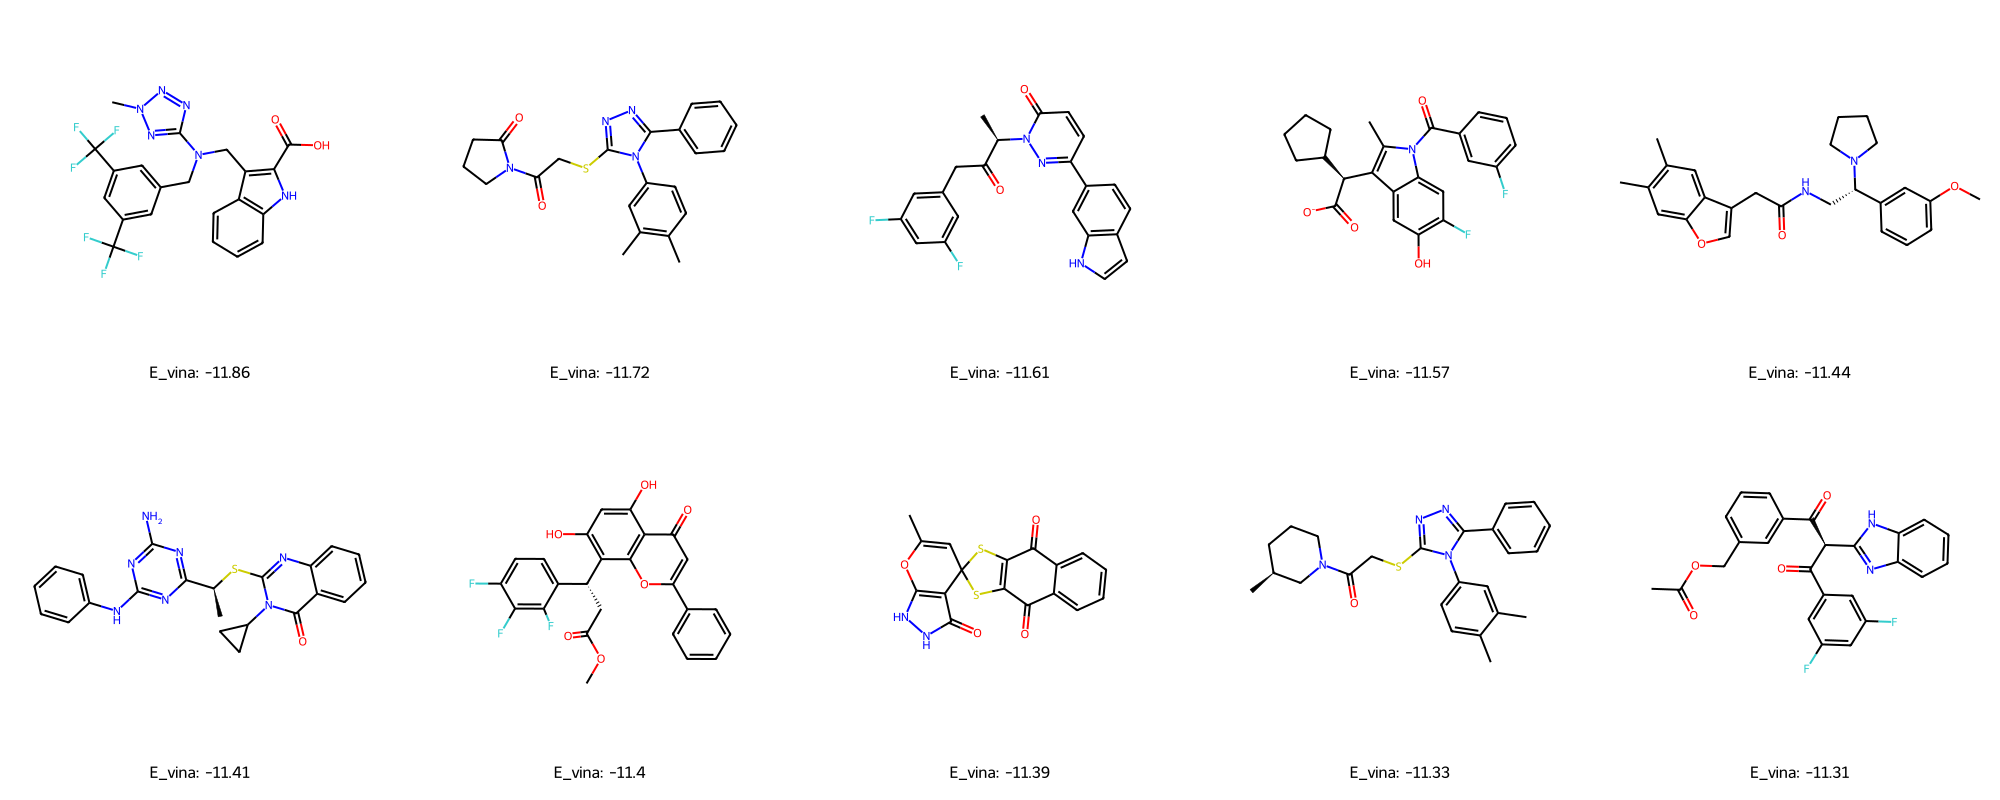

In [ ]:
show_smiles(df["SMILES"])

###Визуализация данных

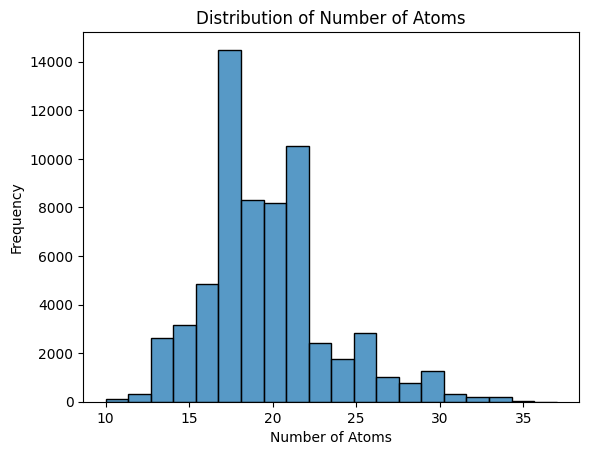

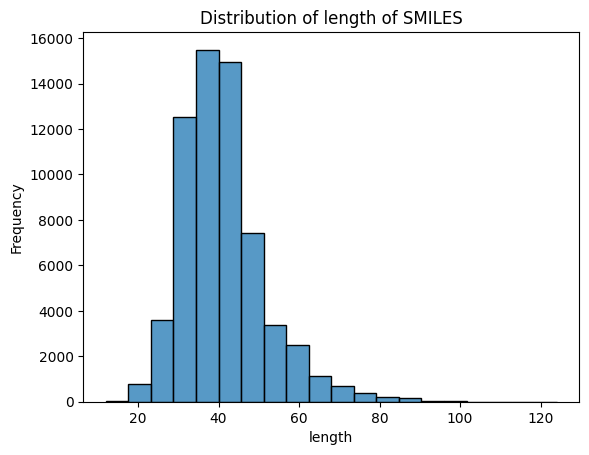

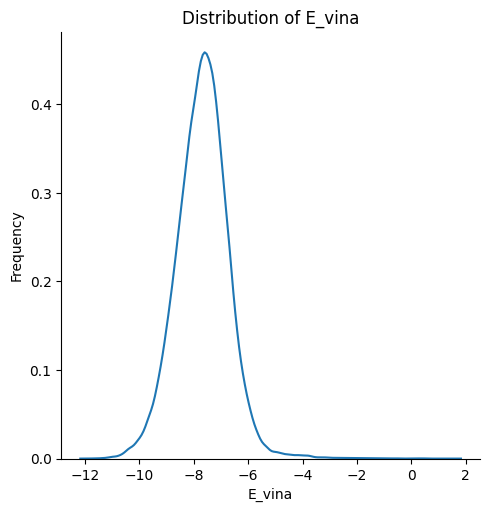

In [ ]:
def histogram_of_distribution(data_frame):
  sns.histplot(data=data_frame, x='NumAtoms', bins=20)
  plt.title('Distribution of Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('Frequency')
  plt.show()

  sns.histplot(data=data_frame, x='SmilesLen', bins=20)
  plt.title('Distribution of length of SMILES')
  plt.xlabel('length')
  plt.ylabel('Frequency')
  plt.show()

  sns.displot(data=data_frame, x='E_vina, kcal/mol', kind = 'kde')
  plt.title('Distribution of E_vina')
  plt.xlabel('E_vina')
  plt.ylabel('Frequency')
  plt.show()



histogram_of_distribution(df)

In [ ]:
df['E_vina, kcal/mol'].median()

-7.66

<Axes: xlabel='SmilesLen', ylabel='E_vina, kcal/mol'>

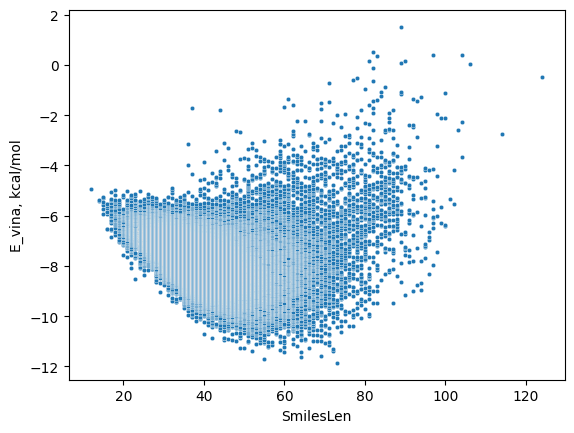

In [ ]:
sns.scatterplot(data=df, x = "SmilesLen", y = "E_vina, kcal/mol", s=10)

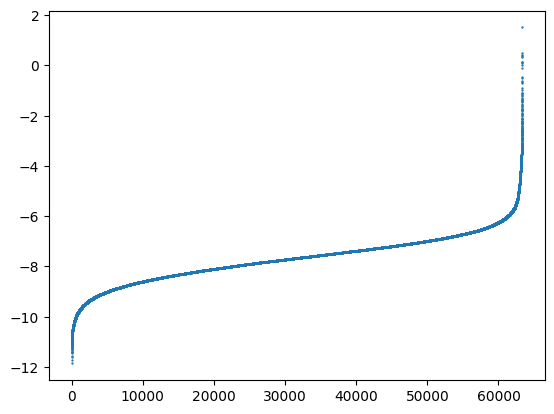

In [ ]:
plt.scatter(np.arange(df.shape[0]), df['E_vina, kcal/mol'], s=0.5)

In [ ]:
def replace_halogen(string):
    """Regex to replace Br, Cl, Se, Si with single letters"""
    br = re.compile('Br')
    cl = re.compile('Cl')
    se = re.compile('Se')
    si = re.compile('Si')
    string = br.sub('W', string)
    string = cl.sub('X', string)
    string = se.sub('Y', string)
    string = si.sub('Z', string)
    return string

In [ ]:
df['SMILES'] = df['SMILES'].apply(lambda x: replace_halogen(x))

<Axes: >

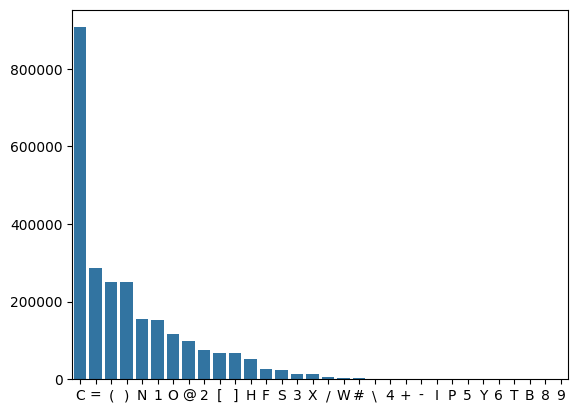

In [ ]:
char_dict = {}
for smi in df["SMILES"]:
    for char in smi:
        if char in char_dict:
            char_dict[char] += 1
        else:
            char_dict[char] = 0
char_dict = dict(sorted(char_dict.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x = char_dict.keys(), y = char_dict.values())

In [ ]:
char_dict.keys()

dict_keys(['C', '=', '(', ')', 'N', '1', 'O', '@', '2', '[', ']', 'H', 'F', 'S', 'l', '3', '/', 'B', 'r', '#', '\\', '+', '4', '-'])

<BarContainer object of 16 artists>

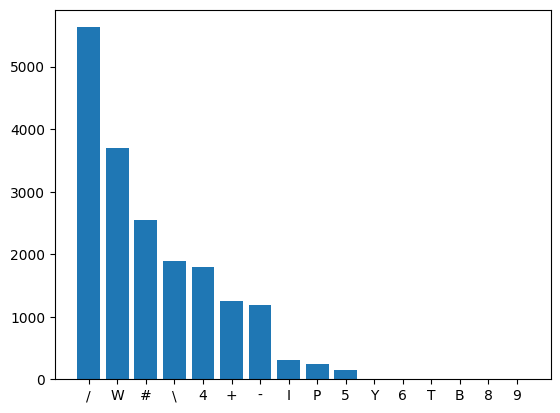

In [ ]:
rare_char_dict = { key : char_dict[key] for key in char_dict if char_dict[key] < 6000}
plt.bar(rare_char_dict.keys(), rare_char_dict.values())

###Удаление слишком длинных/коротких SMILES, а также SMILES с редкими символами

In [ ]:
exclude = [key for key in char_dict if char_dict[key] < 1000]
print(exclude)

['I', 'P', '5', 'Y', '6', 'T', 'B', '8', '9']


In [ ]:
df = df[df['SMILES'].apply(lambda smi: not any(char in smi for char in exclude))]
df = df[df['SmilesLen'] <= 70]
df = df[df['SmilesLen'] >= 20]
print(df.shape)

(61565, 8)


In [ ]:
df['SMILES'] = df['SMILES'].apply(lambda x: x.replace('X', 'Cl'))
df['SMILES'] = df['SMILES'].apply(lambda x: x.replace('W', 'Br'))

Сохранение данных

In [ ]:
df.to_csv("prepared_dataset.csv")

In [ ]:
with open('prepared_smiles.smi', 'w') as f:
  for smi in df.SMILES:
    f.write(smi + '\n')

###Данные из ZINC (https://www.kaggle.com/datasets/basu369victor/zinc250k)

In [ ]:
data = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')

In [ ]:
data.shape

(249455, 4)

In [ ]:
smiles = [smi.rstrip() for smi in data.smiles]

In [ ]:
len(smiles)

249455

In [ ]:
with open('zinc_smiles(1).smi', 'w') as f:
  for smi in smiles:
    f.write(smi + '\n')

<BarContainer object of 34 artists>

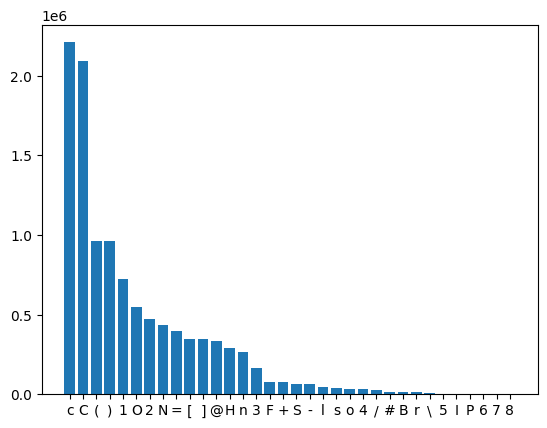

In [ ]:
char_dict = {}
for smi in smiles:
    for char in smi:
        if char in char_dict:
            char_dict[char] += 1
        else:
            char_dict[char] = 0
char_dict = dict(sorted(char_dict.items(), key=lambda item: item[1], reverse=True))
plt.bar(char_dict.keys(), char_dict.values())

In [ ]:
char_dict.keys()

dict_keys(['c', 'C', '(', ')', '1', 'O', '2', 'N', '=', '[', ']', '@', 'H', 'n', '3', 'F', '+', 'S', '-', 'l', 's', 'o', '4', '/', '#', 'B', 'r', '\\', '5', 'I', 'P', '6', '7', '8'])